# Math  1376: Programming for Data Science
---

In [1]:
import numpy as np #We will use numpy in this lecture
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
import pandas as pd

## Module 06: The beginnings of Machine Learning

In this lecture, we begin exploring how to use Python to perform the basics of machine learning. 
We are primarily going to touch on material covered in the initial chapters out of Sebastian Raschka's book [Python Machine Learning (3rd edition)](https://github.com/rasbt/python-machine-learning-book-3rd-edition). 


Specifically, we will selectively sample and build upon material from the following chapters: 

- Chapter 2: Training Machine Learning Algorithms for Classification ***(This notebook's focus)***
- Chapter 3: A Tour of Machine Learning Classifiers Using Scikit-Learn
- Chapter 4: Building Good Training Datasets – Data Preprocessing
- Chapter 5: Compressing Data via Dimensionality Reduction
- Chapter 6: Learning Best Practices for Model Evaluation and Hyperparameter Tuning

In the spirit of making arbitrary and capricious decisions, I declare that everything beyond these chapters is *advanced* and left for topics in a future course or self-study.

## Learning Objectives (and an important note)
---

First, an important note: machine learning concepts will often appear harder than they are. 
Try not to let this discourage you.
If details elude you, just focus on the bigger picture about *why* we are doing something.
The *how* will come with time.

By the end of this notebook, you should be able to
* Explain what supervised learning means.
* Implement and study the capabilities of artificial neurons as classifiers on various types of labeled data.
* Explain the role of both training data and hyperparameters in building classifiers. 
* Understand the importance of linear or "almost" linear separability on the performance of classifiers.

## Notebook contents <a id='Contents'>


* <a href='#perceptron'>Part (a)(i): Our first classifier: the perceptron</a>
<br>

    * <a href='#activity-intuition'>Activity: Build your intuition</a>
    <br><br>

* <a href='#adaline'>Part (a)(ii): ADALINE = ADAptive LInear NEuron</a>
<br><br>
    * <a href='#activity-no-gap'>Activity: A perceptron with linearly separable data and no gap</a>
<br><br>
    
* <a href='#activity-summary'>Activity: Summary</a>

## Part (a)(i): Our first classifier: the perceptron <a id='perceptron'></a>

---

### A list of some useful source material for this section 

- https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch02/ch02.ipynb

- https://en.wikipedia.org/wiki/Perceptron

- https://en.wikipedia.org/wiki/Artificial_neuron

    
<span style='background:rgba(255,255,0, 0.25); color:black'> Run the code cell below and click the "play" button to see the first recorded lecture associated with this notebook.</span>

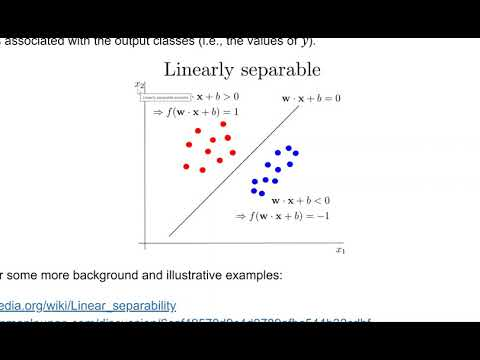

In [3]:
# 1. Running this cell with embed the short recorded lecture associated with this part of the notebook
# 2. Press on the "play" button to start the video.

from IPython.display import YouTubeVideo

YouTubeVideo('bHB5F5fg_Bg', width=800, height=300)

### The concept
---

The perceptron was developed more than half a century ago based on a neuron model. 
When you hear of neural networks or deep learning, you are *basically hearing* about something that connects many things that are *like* perceptrons (there are other types of neuron models) together. 
So, perceptrons are a good place to start our initial meandering into the field of machine leaning.

From Wikipedia (emphasis my own):

> In machine learning, the perceptron is an algorithm for **supervised learning** of **binary classifiers**. A binary classifier is a function which can decide whether or not an input, represented by a vector of numbers, belongs to some specific class. It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector.

What does **supervised learning** mean? Simply put, it means we learn a function that maps inputs to outputs based on *training data* containing example input-output pairs. 

### The mathematics
---

Mathematically, suppose that $\mathbf{x}\in\mathbb{R}^m$ denotes the $m$ features present in the data, then a linear binary classifier defined on $\mathbf{x}$ is represented as the function 
$$
\large    f(\mathbf{w}\cdot\mathbf{x} + b) = \begin{cases}
                        1, & \mathbf{w}\cdot\mathbf{x} + b>0, \\
                        -1, & \text{else}.
                    \end{cases}
$$
Here, $\mathbf{w}$ denotes a $m$-dimensional vector of weights and $b$ is the bias. Both of these must be *learned* from the training data. 
In the evaluation of $f(\mathbf{w}\cdot\mathbf{x} + b)$, we must compute $\mathbf{w}\cdot\mathbf{x}=\sum_{i=1}^m w_ix_i$, which denotes the standard dot product, and can be computed using the `numpy.dot` function that takes as arguments two arrays.


We use the perceptron to make binary decisions, i.e., whether or not data that possess $m$ identifying features should belong to one set or its complement (which are represented by the outputs 1 and -1, respectively). 

<img src="neuron_and_perceptron.png" width=60%>

### A note about the *bias* in various source materials
---

As shown in the figure above (adapted from some of the [source material](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch02/ch02.ipynb)), it is quite typical to refer to the bias as the weight $w_0$ and consider the weight vector as $(m+1)$-dimensional instead of $m$-dimensional. 

Keep this in mind when reviewing other sources. 

We will *not* follow that convention here because the formulas involving the learning of the bias are *different* than the formulas involved with learning the weights $w_1,w_2,\ldots, w_m$. By treating these separately, we avoid any conceptual (and mathematical) confusion regarding the bias term.

### Comparison to a line of best fit
---

Recall the standard regression problem common in statistics of finding a line of best fit (see the prologue notebook to this module).
The idea is to take some given data $\{(x_i,y_i)\}_{i=1}^N$ where the input data $x$ is 1-dimensional and the output data $y$ is also 1-dimensional and try to fit a line to it. 
In other words, we *assume* (usually after inspection of a scatter plot of the data) that a line is a good description of the trend of the data so that our best prediction of $y$ given some value of $x$ is given by $y=f(x)=ax+b$.

We can rephrase the regression problem as trying to *learn* the values of $a$ (which is analogous to the weight vector) and $b$ (which describes a type of bias) from the *training data* $\{(x_i,y_i)\}_{i=1}^N$.

There are many ways to solve the regression problem (e.g., using least squares techniques to determine $a$ and $b$), to analyze the *goodness of fit* of the line, and to study whether any of the underlying assumptions in the formulation/solution of the problem are violated. 

The difference for the perceptron is that the output $y=f(\mathbf{w}\cdot\mathbf{x} + b)$ is either 1 or -1 (not a continuous variable), so we must consider some different algorithmic approaches for solving this problem (i.e., for learning the weights).

### When should a perceptron work?
---

We need the data set to be ***linearly separable***. The idea that linearity plays some role is perhaps not surprising given that the analogy we used involved a line of best fit.

What does linearly separable mean? It means that we can construct a line (for 2-dimensional input data sets), a plane (for 3-dimensional input data sets), or hyperplanes (for 4- and higher-dimensional input data sets) that *separates* the input data space into two parts associated with the output classes (i.e., the values of $y$). 

<img src="linearly_separable_example.png" title='Linearly separable example' width=30%>

See the following for some more background and illustrative examples:

- https://en.wikipedia.org/wiki/Linear_separability

- https://www.commonlounge.com/discussion/6caf49570d9c4d0789afbc544b32cdbf

## A training algorithm for learning weights and bias
---

<span style='background:rgba(255,0,255, 0.25); color:black'> ***Terminology and notation:*** <span>


- Let $\{(\mathbf{x}^{(i)},y^{(i)})\}_{i=1}^N=\{(x_1^{(i)},x_2^{(i)},\ldots,x_m^{(i)},y^{(i)})\}_{i=1}^N$ denote the $N$ training data we use to learn the weights $\mathbf{w}\in\mathbb{R}^m$ and bias $b$. 
<br><br>

- For simplicity, we assume that $y^{(i)}$ values are already scalarized to be 1's and -1's depending on the output classification.
<br><br>

- We conceptualize the *optimal* weights and bias as the vector $\mathbf{w}^\text{opt}$ and scalar $b^\text{opt}$ such that $y^{(i)}=f(\mathbf{w}^\text{opt}\cdot\mathbf{x}^{(i)}+b^\text{opt})$ for all $1\leq i\leq N$.

<span style='background:rgba(255,0,255, 0.25); color:black'> ***Connection to root-finding problems:*** <span>

If the optimal weights and bias are found, then for all $1\leq i\leq N$, we have 

$$y^{(i)}-f(\mathbf{w}^\text{opt}\cdot\mathbf{x}^{(i)}+b^\text{opt})=0.$$ 

We wrote it like this for a reason: it looks like the optimal weights and bias solve a set of root-finding problems!

Recall that most root-finding algorithms require an initial guess of the weights and bias. 
This gives us the first step of the training algorithm.

<span style='background:rgba(255,0,255, 0.25); color:black'> ***Algorithm:*** <span>


**Step 1 (Initialize):** Initialize the weight vector $\mathbf{w}^{(0)}$ and bias $b^{(0)}$ (zero or small random numbers are standard options).


**Step 2 (Update? But, how?)**

The goal is to determine some systematic way to incrementally update the weights and bias so that they approach their optimal values. But, how?

For simplicity in developing the idea, assume $m=1$ (i.e., there is only one feature to the data so $\mathbf{x}=x$ and the $i$th input sample is denoted by $x^{(i)}$), then we seek a weight $w^\text{opt}$ and bias $b^\text{opt}$ such that $w^\text{opt}x^{(i)}+b^\text{opt}>0$ whenever $y^{(i)}=1$ and is less than or equal to zero whenever $y^{(i)}=-1$.

Having updated the weight and bias based on the first $i-1$ data points, suppose we evaluate $f(x^{(i)})$ with these values and observe one of the following scenarios:

<img src="misclassification.png" title="Misclassification implies we need to update weights and bias" width=50%>

We need to update the weights and bias to shift the function $f$ either to the left or right to try to remove this misclassification. 
Increasing the net input $wx+b$ will shift the function to the left while decreasing the net input $wx+b$ will shift the function to the right. 
If this is confusing or seems backwards, try plotting $f(x)=x$ and then plot $f(x+1)=x+1$ and $f(x-1)=x-1$. 

Suppose we need to shift the function to the left.
This implies we observe that $y^{(i)}-f(w^{(i-1)}x^{(i)}+b^{(i)})=2$.

Suppose instead we need to shift the function to the right.
This implies we observe that $y^{(i)}-f(w^{(i-1)}x^{(i)}+b^{(i)})=-2$. 
    
In either case, the misclassification can be used to determine the *sign* of the updates to the weights and bias. 

The updating is in fact given as follows

**Step 2 (Updating):** For $i=1,2,\ldots, N$, do the following:
 
 - Let $\mathbf{w}^{(i-1)}$ and $b^{(i-1)}$ denote the weights and bias used to predict the $i$th output data $y^{(i)}$. 
<br><br> 
 - Let $0<r\leq 1$ denote a ***learning rate***. 
 <br><br>
 - Compute misclassification error: $$y^{(i)}-f(\mathbf{w}^{(i-1)}\cdot\mathbf{x}^{(i)}+b^{(i)})$$
<br><br>
 - Update the weights 
 
 $$\mathbf{w}^{(i)} = \mathbf{w}^{(i-1)} + r\left[y^{(i)}-f(\mathbf{w}^{(i-1)}\cdot\mathbf{x}^{(i)}+b^{(i)})\right]\mathbf{x}^{(i)}$$
 
 and the bias 
 
 $$b^{(i)} = b^{(i-1)} + r\left[y^{(i)}-f(\mathbf{w}^{(i-1)}\cdot\mathbf{x}^{(i)}+b^{(i)})\right].$$
 
**Step 3 (Rinse and Repeat):** We repeat Step 2 until either the misclassifications disappear (or fall below some tolerance) or a maximum number of iterations are reached. The number of times we loop through all the training data to update the weights are called the ***epochs*** of the algorithm. If all misclassification errors disappear, then call the final weights and bias "optimal." If there are still some misclassification errors, then call these final weights and bias "near optimal." 

*If the data are not linearly separable, then we can never get the misclassification errors to completely disappear. We should also not be using a perceptron in that case.*

## Epochs, learning rate, say what now?
---

The learning rate and epochs discussed in steps 2 and 3 above are called ***hyperparameters***. A hyperparameter refers to some variable whose value requires specification in order to run the algorithm. 

What values should we choose for hyperparameters? The answer is: *it depends*. 

Depends on what? The answer is: *on the problem*. 

Oh, well that just clears up everything doesn't it? Problem dependent choices for hyperparameters are necessary to get optimal performance of the algorithm. How is that helpful? The answer is: *it's not*.

You are welcome! A not helpful answer is just what you wanted, isn't it? Well, we can attempt to automate the choice of hyperparameters that are *nearly* optimal based on the data we have to train the model by using **cross-validation** (but, as mentioned before, this is a topic best left for a more advanced course).

### Visualizing the performance of the algorithm over epochs
---

We first visualize the performance with computations below using 1- and 2-dimensional feature spaces involving ***linearly separable*** data, i.e., data for which the algorithm *should* converge if the *epochs* are either sufficiently high (relative to the size of the learning rate and quality of the initial guess).

We will first interrogate the performance on linearly separable data sets that have nice "fat" gaps between the two data sets. 

In [4]:
def activation_function(x, w, b): # This is what performs the classification
    return np.where(np.dot(x,w)+b > 0, 1, -1) # Slick way of using np.where, huh? What is this doing?

In [5]:
def learn_perceptron_weights(x, y, w, b, r, num_epochs): 
    
    n = x.shape[0]
    
    for j in range(num_epochs):
        
        for i in range(n):
            
            error = y[i] - activation_function(x[i], w, b)
            w += r*error*x[i]
            b += r*error
            
    return (w, b)

In [6]:
def create_1d_training_data(num_training=100, gap=0.2): 
    # A function for simulating training data with x in [0,1]
    pt1 = 0.4 # if x < pt1, then y=-1
    pt2 = pt1+gap # if x> pt2, then y=1
    # Probability of a training point being 1 or -1 depends on lengths of [0,pt1] and [pt2,1]
    prob1 = pt1/(pt1+(1-pt2))
    prob2 = (1-pt2)/(pt1+(1-pt2))
    pseudo_data = np.random.uniform(low=0, high=1, size=num_training)
    x_data = np.zeros(num_training)
    for i in range(num_training):
        if pseudo_data[i]<prob1:
            x_data[i] = np.random.uniform(low=0, high=pt1)
        else:
            x_data[i] = np.random.uniform(low=pt2, high=1)
    y_data = np.where(x_data > pt2, 1, -1)
    return (x_data, y_data)

In [7]:
(x_data, y_data) = create_1d_training_data()

In [8]:
def visualize_updates_1d_perceptron(x, y, w, b, r, num_epochs):
    
    fig, ax = plt.subplots(figsize=(10,10))
    plt.axhline(0, linewidth=1, linestyle='--', c='k') #plot typical x-axis
    
    ax.set_ylim([-1.25, 2])
    ax.scatter(x, y, s=50, c='r', label='training data')
    
    x_plot = np.linspace(np.min(x)-0.1*(np.max(x)-np.min(x)), 
                         np.max(x)+0.1*(np.max(x)-np.min(x)), 
                         101)
    y_plot = activation_function(x_plot, w, b)
    ax.plot(x_plot, y_plot, 'b:', linewidth=2, label='initial perceptron')

    ####### Learn the optimal weights and bias ################
    w, b = learn_perceptron_weights(x, y, w, b, r, num_epochs)
    ###########################################################
    
    y_plot = activation_function(x_plot, w, b)
    ax.plot(x_plot, y_plot, 'k-', linewidth=2, label='learned perceptron')
    ax.legend(fontsize=20)
    ax.text(np.mean(x_plot), 1.1, r"Learned $w$=%3.2f and $b$=%3.2f" %(w,b),
            horizontalalignment='center', fontsize=20)

In [9]:
%reset -f out

interact(visualize_updates_1d_perceptron, 
         x = widgets.fixed(x_data),
         y = widgets.fixed(y_data),
         w = widgets.FloatSlider(value=-5, min=-10, max=10, step=0.1),
         b = widgets.FloatSlider(value=1, min=-10, max=10, step=0.1), 
         r = widgets.FloatSlider(value=0.5, min=0.01, max=1, step=0.01), 
         num_epochs = widgets.IntSlider(value=1, min=0, max=1000, step=1))

Flushing output cache (1 entries)


interactive(children=(FloatSlider(value=-5.0, description='w', max=10.0, min=-10.0), FloatSlider(value=1.0, de…

<function __main__.visualize_updates_1d_perceptron(x, y, w, b, r, num_epochs)>

Now for the 2-d example

In [10]:
def create_2d_training_data(num_training=100): 
    # Create training data with two features

    # Now create a box for class -1.
    # The first row is the lower-left point and 
    # second row is upper-right point for this box
    box_1 = np.array([[0.5, 0], [1.5, 4]]) 

    # Similar idea for a box of class 1
    box_2 = np.array([[2, 2], [4, 4]]) 

    # Will assume equal probability of training data being in either box
    pseudo_data = np.random.uniform(low=0, high=1, size=num_training)
    x_data = np.zeros((num_training,2))
    y_data = np.zeros(num_training) 
    for i in range(num_training):
        if pseudo_data[i]<0.5:
            x_data[i,0] = np.random.uniform(low=box_1[0,0], high=box_1[1,0])
            x_data[i,1] = np.random.uniform(low=box_1[0,1], high=box_1[1,1])
            y_data[i] = -1
        else:
            x_data[i,0] = np.random.uniform(low=box_2[0,0], high=box_2[1,0])
            x_data[i,1] = np.random.uniform(low=box_2[0,1], high=box_2[1,1])
            y_data[i] = 1
    return (x_data, y_data)

In [11]:
(x_data, y_data) = create_2d_training_data()

In [12]:
from matplotlib.colors import ListedColormap

def visualize_updates_2d_perceptron(x, y, w1, w2, b, r, num_epochs):
    
    w = np.array([w1, w2])
    
    x1_plot = np.linspace(np.min(x[:,0])-0.1*(np.max(x[:,0])-np.min(x[:,0])), 
                          np.max(x[:,0])+0.1*(np.max(x[:,0])-np.min(x[:,0])), 
                          51)
    x2_plot = np.linspace(np.min(x[:,1])-0.1*(np.max(x[:,1])-np.min(x[:,1])), 
                          np.max(x[:,1])+0.1*(np.max(x[:,1])-np.min(x[:,1])), 
                          51)
    x1_plot, x2_plot = np.meshgrid(x1_plot, x2_plot)
    x_plot = np.vstack((x1_plot.flatten(), x2_plot.flatten())).T
    y_plot = activation_function(x_plot, w, b)
    y_plot = y_plot.reshape(x1_plot.shape)

    fig, axs = plt.subplots(1,2,figsize=(20,10))
    
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    axs[0].contourf(x1_plot, x2_plot, y_plot , alpha=0.2, cmap=cmap)
    
    idx_1 = np.where(y==1)[0]
    idx_0 = np.where(y==-1)[0]
    
    axs[0].scatter(x[idx_1,0], x[idx_1,1], s=50, c='r', marker='x')
    axs[0].scatter(x[idx_0,0], x[idx_0,1], s=50, c='b', marker='o')
    axs[0].set_title('Initial perceptron', fontsize=18)
    
    ####### Learn the optimal weights and bias ################
    w, b = learn_perceptron_weights(x, y, w, b, r, num_epochs)
    ###########################################################
    
    y_plot = activation_function(x_plot, w, b)
    y_plot = y_plot.reshape(x1_plot.shape)
    
    cmap = ListedColormap(colors[:len(np.unique(y))])
    axs[1].contourf(x1_plot, x2_plot, y_plot , alpha=0.2, cmap=cmap)
    
    axs[1].scatter(x[idx_1,0], x[idx_1,1], s=50, c='r', marker='x')
    axs[1].scatter(x[idx_0,0], x[idx_0,1], s=50, c='b', marker='o')
    
    axs[1].set_title('Learned $w$=(%3.2f,%3.2f) and $b$=%3.2f' %(w[0], w[1], b), fontsize=18)

In [13]:
%reset -f out

interact(visualize_updates_2d_perceptron, 
         x = widgets.fixed(x_data),
         y = widgets.fixed(y_data),
         w1 = widgets.FloatSlider(value=1, min=-10, max=10, step=0.1),
         w2 = widgets.FloatSlider(value=-1, min=-10, max=10, step=0.1),
         b = widgets.FloatSlider(value=2, min=-10, max=10, step=0.1), 
         r = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.01), 
         num_epochs = widgets.IntSlider(value=1, min=0, max=1000, step=1))

Flushing output cache (1 entries)


interactive(children=(FloatSlider(value=1.0, description='w1', max=10.0, min=-10.0), FloatSlider(value=-1.0, d…

<function __main__.visualize_updates_2d_perceptron(x, y, w1, w2, b, r, num_epochs)>

<hr style="border:5px solid cyan"> </hr>

## <span style='background:rgba(0,255,255, 0.5); color:black'>Activity: Build your intuition</span><a id='activity-intuition'>
---
     
The purpose of this activity is to build your intuition about the performance of the training algorithm for the perceptron. For each question, you should try the code on different sets of training data with different sized "gaps" in the classes to make sure that your statements/comments are actually correct. 

Feel free to add code/markdown cells below as you work through this activity.

- For different training sets with different gaps, set the number of epochs sufficiently high so that the optimal weights and bias are learned. The optimal weights and bias are *not* unique. They depend upon the initial guesses and learning rates. 
<br><br>
    - For fixed initial guesses, comment on the sensitivity of the optimal weights and bias that are learned as the learning rate is varied.
    <br><br>
    - For a fixed learning rate, comment on the sensitivity of the optimal weights and bias that are learned as the initial guesses are varied.
<br><br>    
- For different training sets with different gaps, fix initial guesses that are *not* optimal. Comment on how many epochs are required to obtain optimal weights and bias as the learning rate is varied.

<hr style="border:5px solid cyan"> </hr>

### The "unreality" of linear separability exposed by realistic data

John Hollinger is a former ESPN analyst/writer who developed some advanced statistics to quantify efficiencies of players and teams in the NBA. He parlayed this into becoming the VP of basketball operations for the Memphis Grizzlies in 2012. If you have ever heard of PER (Player Efficiency Rating) when evaluating a player's chances of winning awards such as MVP, then you are at least somewhat familiar with the contributions of Mr. Hollinger. 

Below, we *crawl* through some online data courtesy of ESPN. By courtesy of ESPN what I actually mean is that according to the terms of service from Disney (the parent company of ESPN): 

> G. Informational and Entertainment Purposes. You understand that the Disney Products are for your personal, noncommercial use and are intended for informational and entertainment purposes only; the content available does not constitute legal, financial, professional, medical or healthcare advice or diagnosis and cannot be used for such purposes.

Anyway, let's see how well team efficiency statistics in the regular season correspond to a predictor of *success* defined by a team making the playoffs. 

In [14]:
# Let's first orient ourselves on the types of data sets we will be using
df_regular_season_temp = pd.read_html('http://www.espn.com/nba/hollinger/teamstats/_/year/2019')[0]

In [15]:
df_postseason_temp = pd.read_html('http://www.espn.com/nba/hollinger/teamstats/_/year/2019/seasontype/3')[0]

In [16]:
df_regular_season_temp

,0,1,2,3,4,5,6,7,8,9,10,11
0,Hollinger Stats - Offensive Efficiency,Hollinger Stats - Offensive Efficiency,Hollinger Stats - Offensive Efficiency,Hollinger Stats - Offensive Efficiency,Hollinger Stats - Offensive Efficiency,Hollinger Stats - Offensive Efficiency,Hollinger Stats - Offensive Efficiency,Hollinger Stats - Offensive Efficiency,Hollinger Stats - Offensive Efficiency,Hollinger Stats - Offensive Efficiency,Hollinger Stats - Offensive Efficiency,Hollinger Stats - Offensive Efficiency
1,RK,TEAM,PACE,AST,TO,ORR,DRR,REBR,EFF FG%,TS%,OFF EFF,DEF EFF
2,1,Golden State,103.2,20.7,12.6,22.5,77.1,51.0,56.5,59.6,113.9,106.5
3,2,Houston,100.4,16.0,12.0,22.8,74.4,48.1,54.2,58.1,112.5,107.9
4,3,Milwaukee,105.4,18.4,12.0,20.8,80.3,52.3,55.0,58.3,111.5,103.0
5,4,Portland,101.6,16.7,12.1,26.6,77.9,52.8,52.8,56.9,111.4,108.1
6,5,San Antonio,100.4,18.3,11.0,21.0,79.4,50.5,53.4,57.2,111.1,108.3
7,6,Toronto,102.5,18.4,12.4,21.9,77.1,50.2,54.3,57.9,110.9,104.3
8,7,Philadelphia,104.0,18.9,12.9,24.5,78.6,52.3,53.2,57.4,110.4,107.1
9,8,Boston,102.0,19.0,11.5,21.6,77.0,49.3,53.4,56.7,110.1,104.9


In [17]:
df_postseason_temp

,0,1,2,3,4,5,6,7,8,9,10,11
0,Hollinger Playoff Stats - Offensive Efficiency,Hollinger Playoff Stats - Offensive Efficiency,Hollinger Playoff Stats - Offensive Efficiency,Hollinger Playoff Stats - Offensive Efficiency,Hollinger Playoff Stats - Offensive Efficiency,Hollinger Playoff Stats - Offensive Efficiency,Hollinger Playoff Stats - Offensive Efficiency,Hollinger Playoff Stats - Offensive Efficiency,Hollinger Playoff Stats - Offensive Efficiency,Hollinger Playoff Stats - Offensive Efficiency,Hollinger Playoff Stats - Offensive Efficiency,Hollinger Playoff Stats - Offensive Efficiency
1,RK,TEAM,PACE,AST,TO,ORR,DRR,REBR,EFF FG%,TS%,OFF EFF,DEF EFF
2,1,Golden State,100.9,20.3,13.3,24.8,76.6,51.4,54.8,58.9,112.3,108.6
3,2,Denver,95.1,17.8,8.8,27.4,74.8,50.7,49.6,53.9,111.3,109.5
4,3,San Antonio,93.9,16.9,8.1,24.2,76.8,50.6,50.3,54.2,111.1,110.8
5,4,Milwaukee,102.2,18.0,11.4,21.7,83.0,53.5,52.3,56.0,109.0,100.2
6,5,Toronto,98.4,17.4,11.3,18.9,77.7,48.3,51.5,56.1,107.9,101.4
7,6,Houston,99.8,14.2,14.3,23.1,75.0,49.9,53.7,57.4,107.8,104.4
8,7,LA Clippers,105.6,17.8,12.8,21.9,74.5,46.6,51.1,56.3,107.3,119.3
9,8,Portland,98.8,14.7,11.3,24.4,72.4,48.3,50.1,54.1,106.7,109.7


In [18]:
Off_Eff = []
Def_Eff = []

y = []

iter = 0
for year in range(2009, 2020):
    url = 'http://www.espn.com/nba/hollinger/teamstats/_/year/' + str(year)
    df_regular_season = pd.read_html(url)[0]
    Off_Eff.append(df_regular_season.loc[2:, 10].values)
    Def_Eff.append(df_regular_season.loc[2:, 11].values)
    
    N = len(df_regular_season.loc[2:, 1].values)
    
    y.append(-np.ones(N))
    url += '/seasontype/3'
    df_playoffs = pd.read_html(url)[0]
    
    playoff_teams = df_playoffs.loc[2:,1].values
    all_teams = df_regular_season.loc[2:,1].values
    for i in range(16):
        for j in range(N):
            if playoff_teams[i] == all_teams[j]:
                y[iter][j] = 1
    iter += 1

In [19]:
Off_Eff_All = np.concatenate(Off_Eff).astype('float')
Def_Eff_All = np.concatenate(Def_Eff).astype('float')

bball_features = np.vstack((Off_Eff_All.flatten(), Def_Eff_All.flatten())).T

playoffs_All = np.concatenate(y)

In [20]:
idx_playoffs = np.where(playoffs_All==1)[0]
idx_no_playoffs = np.where(playoffs_All==-1)[0]

Text(0.5, 1.0, 'Playoff Teams (red) and Non-Playoff Teams (blue)')

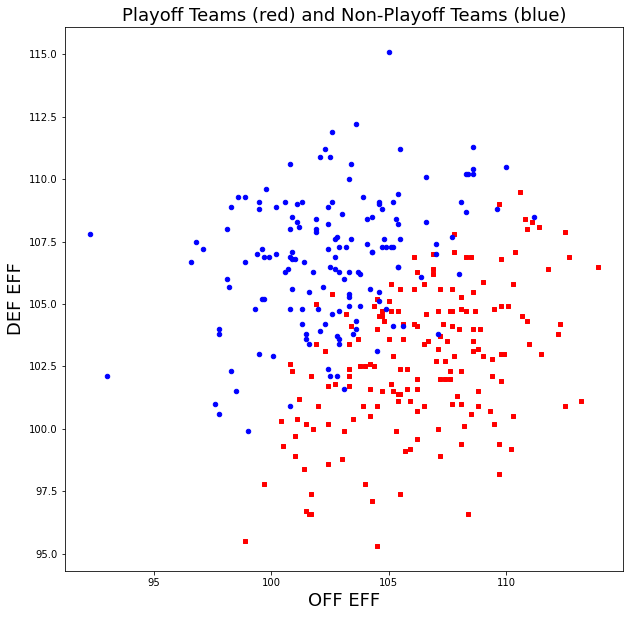

In [21]:
fig = plt.figure(figsize=(10,10))

plt.scatter(bball_features[idx_playoffs, 0], bball_features[idx_playoffs, 1], 
            s=20, c='r', marker='s')

plt.scatter(bball_features[idx_no_playoffs,0], bball_features[idx_no_playoffs, 1], 
            s=20, c='b', marker='o')

plt.xlabel('OFF EFF', fontsize=18)
plt.ylabel('DEF EFF', fontsize=18)

plt.title('Playoff Teams (red) and Non-Playoff Teams (blue)', fontsize=18)

### Okay, now what?

The data above sure *looks* like it is reasonably separated into two distinct classes although there is a *bit* of overlap. 

However, it is ***not*** linearly separable, which will mean bad things for the convergence of the training algorithm for the perceptron. We can still *try* to train a perceptron on this data. It just may not work. (Okay, it is *guaranteed* to not work.)

However, we still need to address one key point: how do we *train* the perceptron?! In other words, how do we learn the weights and bias required to define the line that separates the *feature space* of offensive and defensive efficiency into playoff vs non-playoff teams?

### Let's try to train a perceptron on the basketball data that are *almost* linearly separable (meaning, not linearly separable)

- Well, convergence is *not* going to happen, but with enough epochs, the updates may just *settle down* towards some good results.

In [22]:
%reset -f out

interact(visualize_updates_2d_perceptron, 
         x = widgets.fixed(bball_features),
         y = widgets.fixed(playoffs_All),
         w1 = widgets.FloatSlider(value=1, min=-10, max=10, step=0.1),
         w2 = widgets.FloatSlider(value=-1, min=-10, max=10, step=0.1),
         b = widgets.FloatSlider(value=-2, min=-10, max=10, step=0.1), 
         r = widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.01), 
         num_epochs = widgets.IntSlider(value=1, min=0, max=1000, step=1))

Flushing output cache (4 entries)


interactive(children=(FloatSlider(value=1.0, description='w1', max=10.0, min=-10.0), FloatSlider(value=-1.0, d…

<function __main__.visualize_updates_2d_perceptron(x, y, w1, w2, b, r, num_epochs)>

### Some closing remarks on the perceptron and foreshadowing
---

Linear separability is a ***strict requirement*** for the perceptron. 

The algorithms for learning the weights and bias in a perceptron will not work unless data are linearly separable. 

This is more than just mildly annoying, it is essentially impractical in many cases where we observe an ***almost*** linear separability.

<img src="almost_linearly_separable_example.png" title='Almost separable' width=30%>

There is something called a ***kernel trick*** that is very common in machine learning. 

While we will get to this in a later notebook, the basic premise is this: Maybe there is a function (called the kernel) that can transform the data in such a way that this transformed data are linearly separable. Then, we simply carry out our usual analysis except on this transformed data. 

When can we do this? Well, if it looks like there is a way to separate the data in some nonlinear way, then there is hope that we can figure out some kernel that allows us to linearly separate the transformed data. 

<img src="not_linearly_separable_example.png" title='Nonlinearly separable illustration (what is the kernel trick?)' width=30%>

## Part (a)(ii): [ADALINE = ADAptive LInear NEuron](https://en.wikipedia.org/wiki/ADALINE) <a id='adaline'>
---
    
<span style='background:rgba(255,255,0, 0.25); color:black'> Run the code cell below and click the "play" button to see the second recorded lecture associated with this notebook.</span>

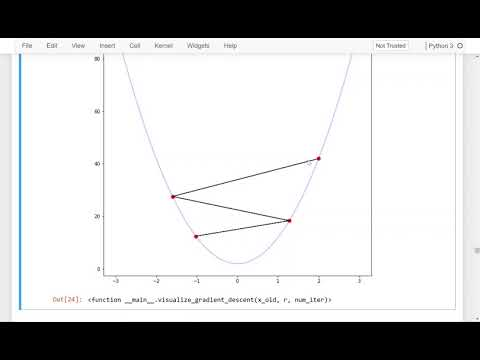

In [23]:
# 1. Running this cell with embed the short recorded lecture associated with this part of the notebook
# 2. Press on the "play" button to start the video.

from IPython.display import YouTubeVideo

YouTubeVideo('PjRX2ys-oUk', width=800, height=300)

<span style='background:rgba(255,0,255, 0.25); color:black'> ***Key points:*** <span>


- When data are only *almost* linearly separable instead of absolutely linearly separable, we are going to have to live with some misclassifications (i.e., *predictions* given by $f(\mathbf{w}^\text{opt}\cdot\mathbf{x}^{(i)}+b^\text{opt})$  that do not equal the reality of $y^{(i)}$ for some subset of $1\leq i\leq N$). 
<br><br>
- This means that what is *optimal* will in general mean that we minimize the misclassification percent rather than simply make it zero. This idea is explored more in our next neuron model ADALINE, so just be patient for now.
<br><br>
- ADALINE is an alternative neuron model developed a few years after the perceptron was introduced. 
<br><br>
- Unlike the perceptron that learns the weights and bias based on the misclassification error being -2, 0, or 2 due to the use of a step-activation function acting on the *net input function* defined by $\mathbf{w}\cdot\mathbf{x} + b$, the activation function in ADALINE is the identity function, which means we simply use the errors defined by $y^{(i)} - \left(\mathbf{w}\cdot\mathbf{x}^{(i)} + b\right)$ to learn the weights and bias. 
<br><br>
- Once the weights and bias are learned, we still compute $f\left(\mathbf{w}\cdot\mathbf{x}+b\right)$ to classify any particular feature vector $\mathbf{x}$. The function $f$ from before is now considered a ***quantizer*** (as opposed to the activation function, which is now the identity function) that maps the net value into the class. 

We summarize this in the figure below. 

<img src="perceptron_vs_ADALINE.png" width=50%>

<span style='background:rgba(255,0,255, 0.25); color:black'> ***Summary of main difference:*** <span>

> While $y$ is just -1's and 1's, the output of $\left(\mathbf{w}\cdot\mathbf{x} + b\right)$ is *continuous*, so the *error* defined by $y^{(i)} - \left(\mathbf{w}\cdot\mathbf{x}^{(i)} + b\right)$ does not just take on discrete values but instead provides a number corresponding to *how much* we are right/wrong.

### How does this change the way in which we learn the weights?

We first write the **sum of square errors (SSE)** from the $N$ training data as the *cost function* (sometimes called an *objective* function)
$$
 \large   J(\mathbf{w},b) = \frac{1}{2}\sum_{i=1}^N \left[y^{(i)}-\left(\mathbf{w}\cdot\mathbf{x}^{(i)}+b\right)\right]^2. 
$$

Observe that $J(\mathbf{w},b)$ is a *quadratic* function over the space of weights and bias. The *objective* is to learn the weights and bias that *minimize* the *cost* function. This is conceptualized in the picture below.

<img src="cost-functional.png" title="The cost function is like a big bowl" width=50%>

### There is a unique minimum?

***Correct!*** Since the cost function is a quadratic function, it has a unique global minimum even if the data are not linearly separable! (This is the part where you say "ooohhh".)

This means that you can always train an ADALINE...at least theoretically...

### Approximating the minimum with [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)

First, a quick review of some useful facts from calculus and how we use them (you only need to understand how to apply these, so if you are not familiar with calculus, don't worry). 

- The [gradient](https://en.wikipedia.org/wiki/Gradient) of a scalar valued multivariate function evaluated at some input is a *vector* that points in the direction of greatest increase of function values. This means that the *negative* of the gradient at some input will point in the direction of greatest *decrease* of function values. 
<br><br> 

   - Why is this important to us? We want to minimize a function, so we will be using the *negative gradient*.
<br><br>

   - What do we need to be aware of? The *length* of the gradient vector (also called its magnitude) can complicate the decision making process in terms of how far we should step in the direction of the negative gradient.
   <br><br>
       - If the length of the gradient vector is too large, then we may step *too far* so that we end up *increasing* the value of the function instead of *decreasing* the value! This is just plain counterproductive. 
    <br><br>
       - If the length of the gradient is too small or we just choose to make too small of steps, then it may take *way too long* to have this method converge. 
<br><br>

The image below may prove useful to refer as it summarizes why we move in the direction of the negative gradient.

<img src="cost-functional-gradient.png" title="The negative direction of gradient is what we want!" width="50%" />

Below, we demonstrate the gradient descent algorithm for a 1-D function that shares similarities with the "parabolic bowl" shown above.

In [24]:
# Consider the quadratic f(x)=20*x^2 + 2, with derivative 40*x and minimum at x=0

def visualize_gradient_descent(x_old, r, num_iter):
    f = lambda x: 10*x**2 + 2
    df = lambda x: 20*x
    
    x = np.linspace(-3, 3, 100)
    y = f(x)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(x, y, 'b', linewidth=2, alpha=0.25)
    
    ax.scatter(x_old, f(x_old), s=50, c='r')
    
    for i in range(num_iter):
        x_new = x_old - r*df(x_old)
        ax.scatter(x_new, f(x_new), s=50, c='r')
        ax.arrow(x=x_old, y=f(x_old), dx=(x_new-x_old), dy=(f(x_new)-f(x_old)))
        x_old = x_new

In [25]:
%reset -f out

interact(visualize_gradient_descent, 
         x_old = widgets.FloatSlider(value=2, min=0.1, max=3, step=0.1),
         r = widgets.FloatText(value=0.025, step=0.01),
         num_iter = widgets.IntSlider(value=1, min=1, max=1000, step=1))

Flushing output cache (2 entries)


interactive(children=(FloatSlider(value=2.0, description='x_old', max=3.0, min=0.1), FloatText(value=0.025, de…

<function __main__.visualize_gradient_descent(x_old, r, num_iter)>

### Some gradient details for the cost functional (this is not as bad as it may look)
---

<span style='background:rgba(255,0,255, 0.25); color:black'> ***Key points:*** <span>

- The gradient is a vector of partial derivatives where the $j$th component of the vector is the partial derivative of the function with respect to the $j$th input variable. 
<br><br>
- If there are $m$ features in our data, then the gradient is an $(m+1)$-dimensional vector because there are $m$ weights and 1 bias, i.e., $J(\mathbf{w}, b)$ is a function of $(m+1)$ variables.
<br><br>
- The partial derivatives of $J(\mathbf{w},b)$ are denoted by
$$
    \frac{\partial J}{\partial w_j} = -\sum_{i=1}^N \Big(\left[y^{(i)}-\left(\mathbf{w}\cdot\mathbf{x}^{(i)}+b\right)\right]x_j^{(i)}\Big)
$$
     and
$$
    \frac{\partial J}{\partial b} = -\sum_{i=1}^N \left[y^{(i)}-\left(\mathbf{w}\cdot\mathbf{x}^{(i)}+b\right)\right].
$$
     Then, the gradient of $J(\mathbf{w},b)$, denoted by $\nabla J(\mathbf{w},b)$, is given by the $(m+1)$-dimensional vector
$$
\large    \nabla J(\mathbf{w}, b) = \left[\begin{array}{c} 
                                    \frac{\partial J}{\partial w_1} \\
                                    \frac{\partial J}{\partial w_2} \\
                                    \vdots \\
                                    \frac{\partial J}{\partial w_m} \\
                                    \frac{\partial J}{\partial b}
                                    \end{array}\right].
$$

### Pulling it all together
---

Taking all of the above together, we arrive at the rather simple approach to updating a current guess of weights and bias. 


- Given a ***learning rate***, denoted by $r$, determine the additive updates to the weights and bias using the following
$$
     \left[\begin{array}{c} 
                 \Delta w_1 \\
                 \Delta w_2 \\
                 \vdots \\
                  \\
                 \Delta w_m \\
                 \Delta b
                 \end{array}\right] =  -r\left[\begin{array}{c} 
                                    \frac{\partial J}{\partial w_1} \\
                                    \frac{\partial J}{\partial w_2} \\
                                    \vdots \\
                                    \frac{\partial J}{\partial w_m} \\
                                    \frac{\partial J}{\partial b}
                                    \end{array}\right] = -r\nabla J(\mathbf{w}, b)
$$
Simply put, this means that for $1\leq j\leq m$, 
$$
    \Delta w_j = r\sum_{i=1}^N \Big(\left[y^{(i)}-\left(\mathbf{w}\cdot\mathbf{x}^{(i)}+b\right)\right]x_j^{(i)}\Big),
$$
and
$$
    \Delta b = r\sum_{i=1}^N \left[y^{(i)}-\left(\mathbf{w}\cdot\mathbf{x}^{(i)}+b\right)\right].
$$

    In other words, the learning rate determines how far we move in the direction of the negative gradient (i.e., it dictates the step size). We will see just how important it is to choose this hyperparameter correctly.

### What are the epochs now?

Note that now we update all of the weights using all of the training data at once. An epoch describes how many times we compute the gradient and update the weights just as before. 

### Wait one minute, how is this different than finding a linear function of best fit?

It is basically the same thing. In fact, the gradient descent used in the ADELINE algorithm to learn the weights and bias will just converge (well, maybe) to what we would get if we just used [least squares](https://en.wikipedia.org/wiki/Linear_least_squares) (which is also related to standard [regression](https://en.wikipedia.org/wiki/Linear_regression) from statistics). 

Why did I say *maybe* about the convergence? Well, the gradient descent algorithm is iterative and can be a bit sensitive to initial conditions (i.e., initial guesses of weights and bias) and the learning rate $r$ as hinted at above. 
We explore this in the code cell below.

Well gosh, if there are all these issues, then why don't we just use least squares to find the function $\mathbf{w}\cdot\mathbf{x}+b$ instead of gradient descent?
Least squares will just give the solution using a closed-form expression. No iterations necessary. 

This is a good question for you to research. You will find the answer pretty quickly if you read about the [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) method that is actually preferred in practice for big data sets.

As you learn more about machine learning and computational science in general, it is a good idea for you to conceptualize a taxonomy of scenarios where you may prefer using one method to another. If there are at least two algorithms/approaches to solve any problem, there will always be problems where one method works better than another. It is good to know when and why this happens. This usually requires learning more about mathematics (linear algebra and numerical analysis), statistics (including some basic probability theory), and computer science. You do *not* need to master any or all of these, but it is best to develop a deep understanding in at least one of those areas while being effectively *literate/knowledgeable/fluent* in the language of the others. 

### Now we play!

Back to the 1-D and 2-D examples.

In [26]:
def quantizer(x, w, b): #Really the same thing as the activation function from before
    return np.where(np.dot(x,w)+b > 0, 1, -1)

In [27]:
def learn_ADALINE_weights(x, y, w, b, r, num_epochs):
    
    for j in range(num_epochs):
        errors = y - (np.dot(x,w)+b)
        w += r*np.dot(x.T,errors)
        b += r*np.sum(errors)
    
    return (w, b, errors)

In [28]:
def visualize_updates_1d_ADALINE(x, y, w, b, r, num_epochs):
    
    x_plot = np.linspace(np.min(x)-0.1*(np.max(x)-np.min(x)), 
                         np.max(x)+0.1*(np.max(x)-np.min(x)), 
                         101)
    y_plot = quantizer(x_plot,w,b)

    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(x_plot, y_plot, 'b:', linewidth=2, label='initial classification')

    ax.set_ylim([-1.25, 1.75])
    ax.scatter(x, y, s=50, c='r')

    num_training_data = np.size(x)
    
    ####### Learn the optimal weights and bias ################
    w, b, errors = learn_ADALINE_weights(x, y, w, b, r, num_epochs)
    ###########################################################
    
    y_plot = quantizer(x_plot, w, b)
    ax.plot(x_plot, y_plot, 'k', linewidth=2, label='learned classification')
    
    ax.plot(x_plot, w*x_plot+b, 'k-.', linewidth=1, label='net input')
    
    ax.legend(fontsize=20)
    
    ax.axhline(y=0)
    ax.text(np.mean(x_plot), 1.1, r"Learned $w$=%3.2f and $b$=%3.2f" %(w,b),
            horizontalalignment='center', fontsize=20)
    
    ax.set_title('$J(w,b)$=%3.2e' %(0.5*np.sum(errors**2)), fontsize=18)

In [29]:
(x_data, y_data) = create_1d_training_data()

In [30]:
%reset -f out

interact(visualize_updates_1d_ADALINE, 
         x = widgets.fixed(x_data),
         y = widgets.fixed(y_data),
         w = widgets.FloatSlider(value=1.5, min=-10, max=10, step=0.1),
         b = widgets.FloatSlider(value=-1, min=-10, max=10, step=0.1), 
         r = widgets.fixed(1e-2), 
         num_epochs = widgets.IntSlider(value=1, min=1, max=1000, step=1))

Flushing output cache (1 entries)


interactive(children=(FloatSlider(value=1.5, description='w', max=10.0, min=-10.0), FloatSlider(value=-1.0, de…

<function __main__.visualize_updates_1d_ADALINE(x, y, w, b, r, num_epochs)>

### Now remove the gap in the 1-D data

In [31]:
(x_data, y_data) = create_1d_training_data(gap=0)

In [32]:
%reset -f out

interact(visualize_updates_1d_ADALINE, 
         x = widgets.fixed(x_data),
         y = widgets.fixed(y_data),
         w = widgets.FloatSlider(value=1.5, min=-10, max=10, step=0.1),
         b = widgets.FloatSlider(value=-1, min=-10, max=10, step=0.1), 
         r = widgets.fixed(1e-2), 
         num_epochs = widgets.IntSlider(value=1, min=0, max=1000, step=1))

Flushing output cache (1 entries)


interactive(children=(FloatSlider(value=1.5, description='w', max=10.0, min=-10.0), FloatSlider(value=-1.0, de…

<function __main__.visualize_updates_1d_ADALINE(x, y, w, b, r, num_epochs)>

<hr style="border:5px solid cyan"> </hr>

## <span style='background:rgba(0,255,255, 0.5); color:black'>Activity: A perceptron with linearly separable data and no gap<a id='activity-no-gap'></a>
---

Create a code cell below to try learning the weights for a **perceptron** when the data are linearly separable but without a well-defined gap as above. Comment on what you see in a Markdown cell.

<hr style="border:5px solid cyan"> </hr>

In [33]:
def visualize_updates_2d_ADALINE(x, y, w1, w2, b, r, num_epochs):
    w = np.array([w1, w2])
    
    x1_plot = np.linspace(np.min(x[:,0])-0.1*(np.max(x[:,0])-np.min(x[:,0])), 
                          np.max(x[:,0])+0.1*(np.max(x[:,0])-np.min(x[:,0])), 
                          51)
    x2_plot = np.linspace(np.min(x[:,1])-0.1*(np.max(x[:,1])-np.min(x[:,1])), 
                          np.max(x[:,1])+0.1*(np.max(x[:,1])-np.min(x[:,1])), 
                          51)
    x1_plot, x2_plot = np.meshgrid(x1_plot, x2_plot)
    x_plot = np.vstack((x1_plot.flatten(), x2_plot.flatten())).T
    y_plot = activation_function(x_plot, w, b)
    y_plot = y_plot.reshape(x1_plot.shape)

    fig, axs = plt.subplots(1,2,figsize=(20,10))
    
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    axs[0].contourf(x1_plot, x2_plot, y_plot , alpha=0.2, cmap=cmap)
    
    idx_1 = np.where(y==1)[0]
    idx_0 = np.where(y==-1)[0]
    
    axs[0].scatter(x[idx_1,0], x[idx_1,1], s=50, c='r', marker='x')
    axs[0].scatter(x[idx_0,0], x[idx_0,1], s=50, c='b', marker='o')
    axs[0].set_title('Initial ADALINE', fontsize=18)
    
    ####### Learn the optimal weights and bias ################
    w, b, errors = learn_ADALINE_weights(x, y, w, b, r, num_epochs)
    ###########################################################
    
    y_plot = activation_function(x_plot, w, b)
    y_plot = y_plot.reshape(x1_plot.shape)
    
    cmap = ListedColormap(colors[:len(np.unique(y))])
    axs[1].contourf(x1_plot, x2_plot, y_plot , alpha=0.2, cmap=cmap)
    
    axs[1].scatter(x[idx_1,0], x[idx_1,1], s=50, c='r', marker='x')
    axs[1].scatter(x[idx_0,0], x[idx_0,1], s=50, c='b', marker='o')
    
    axs[1].set_title('Learned $w$=(%3.2f,%3.2f) and $b$=%3.2f' %(w[0], w[1], b), fontsize=18)
    
    axs[1].set_title('$J(w,b)$=%3.2e' %(0.5*np.sum(errors**2)), fontsize=18)

In [34]:
%reset -f out

# Create training data
num_training = 100
bbox_1 = np.array([[0.5, 0], [1.5, 4]]) #first row is lower-left point and second row is upper-right point of class -1
bbox_2 = np.array([[2, 2], [4, 4]]) # " " of class 1
# Will assume equal probability of training data being in either box
pseudo_data = np.random.uniform(low=0, high=1, size=num_training)
x_data = np.zeros((num_training,2))
y_data = np.zeros(num_training)
for i in range(num_training):
    if pseudo_data[i]<0.5:
        x_data[i,0] = np.random.uniform(low=bbox_1[0,0], high=bbox_1[1,0])
        x_data[i,1] = np.random.uniform(low=bbox_1[0,1], high=bbox_1[1,1])
        y_data[i] = -1
    else:
        x_data[i,0] = np.random.uniform(low=bbox_2[0,0], high=bbox_2[1,0])
        x_data[i,1] = np.random.uniform(low=bbox_2[0,1], high=bbox_2[1,1])
        y_data[i] = 1

interact(visualize_updates_2d_ADALINE, 
         x = widgets.fixed(x_data),
         y = widgets.fixed(y_data),
         w1 = widgets.FloatSlider(value=1, min=-10, max=10, step=0.1),
         w2 = widgets.FloatSlider(value=-1, min=-10, max=10, step=0.1),
         b = widgets.FloatSlider(value=2, min=-10, max=10, step=0.1), 
         r = widgets.fixed(1e-3), 
         num_epochs = widgets.IntSlider(value=1, min=1, max=1000, step=1))

Flushing output cache (1 entries)


interactive(children=(FloatSlider(value=1.0, description='w1', max=10.0, min=-10.0), FloatSlider(value=-1.0, d…

<function __main__.visualize_updates_2d_ADALINE(x, y, w1, w2, b, r, num_epochs)>

### Revisiting the basketball data with an ADALINE

In [35]:
%reset -f out

interact(visualize_updates_2d_ADALINE, 
         x = widgets.fixed(bball_features),
         y = widgets.fixed(playoffs_All),
         w1 = widgets.FloatSlider(value=1, min=-10, max=10, step=0.1),
         w2 = widgets.FloatSlider(value=-1, min=-10, max=10, step=0.1),
         b = widgets.FloatSlider(value=-2, min=-10, max=10, step=0.1), 
         r = widgets.fixed(1e-7), 
         num_epochs = widgets.IntSlider(value=1, min=0, max=1000, step=1))

Flushing output cache (1 entries)


interactive(children=(FloatSlider(value=1.0, description='w1', max=10.0, min=-10.0), FloatSlider(value=-1.0, d…

<function __main__.visualize_updates_2d_ADALINE(x, y, w1, w2, b, r, num_epochs)>

## Additional important concepts
---

1. Many machine learning algorithms benefit from [***feature scaling***](https://en.wikipedia.org/wiki/Feature_scaling) (sometimes called *data normalization*). Gradient descent in particular benefits from feature scaling. What is feature scaling? It is a *pre-processing* of data. Perhaps the most common feature scaling method is ***standardization***. The basic idea is that by re-scaling the ranges of the individual features into comparable length scales, we can better assess how to weight the individual features based on their importance in explaining the variation in data. 

> Imagine we collect data on heights and weights of adults, and then try to predict some health outcome based on this data (e.g., whether or not they have arthritis, heart disease, or other conditions that we believe may be linked to an individual's size). If the height is in feet, then the range might be $[4, 7]$, and if the weight is in pounds, then the range might be $[70, 500]$. These disparate magnitudes and ranges of values will often negatively impact our machine learning algorithm. Standardization (also called Z-score normalization) will transform each feature so that its sample mean is zero and sample standard deviation is one. This will generally improve the performance of the machine learning algorithm. 

You can Google "importance of standardization of data" to get more information on the topic. We simply mention it is important here.

2. Variants of gradient descent may be required for large data sets. While we are dealing with relatively small data sets for the purposes of learning how to do things, you should be aware of some important variants of algorithms that rely on gradient descent that are useful for "big data." These include [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) and mini-batch gradient descent. 

## A useful lesson in failure
---

It is sometimes useful to understand a *bad* example. 
I just happened to create the original version of this notebook mere days after the NFL "Zoom" Draft of 2020.
I really tried to incorporate some data relevant to the draft into this notebook. 
Below, I describe my thought process and why I ultimately failed.

At the NFL combine, players that may be drafted have various physical and mental attributes measured. 
For player $X$, let $\mathbf{x}=(x_1,x_2,\ldots,x_m)$ denote the $m$-attributes that are measured. 
Perhaps $x_1$ denotes height, $x_2$ denotes the weight, $x_3$ denotes the 40-yard dash time, $x_4$ denotes the number of times the player bench presses 225lbs, $x_5$ denotes how high the player can jump, and so on (maybe the last attribute $x_m$ denotes their score on the Wonderlic test, which seems to be important more for quarterbacks and offensive lineman although even that is debatable). 


A practical question is: can we analyze past combine data for each position and develop a perceptron to predict whether or not a player at a particular position will perform at a pro-bowl level?

### The lesson learned
---
Why did I say this is a bad example? Well, I pulled *years* (5-10 years) of combine data from pro-football-reference.com at various skill positions (QB, RB, WR), and I could *not* see any approximate separability (even with a kernel trick) in the data. I *think* there are too many confounding factors in the data that impact player success beyond individual physical/mental features such as the quality of the team that drafts the player, how the player's talents fit into the style of the team, and of course injuries (and suspensions) that derail many careers. 

***So, what is the lesson?*** It is basically the same lesson you probably learned when computing lines of best fit, which is that not every data set should be modeled with a line! Data science follows the same rules as all of computational science and statistics in that no single method should be universally applied to every problem. This is just a silly thing to assume. Best to get this point deep into your mind as early as possible.
    
### A good question: what happens if there are multiple classes?

There are plenty of prestigious accolades an NFL player may receive: Pro-Bowler, All-Pro, All-Decade, Hall of Fame, or even all of these. 
So, what happens in this case? 
Or, in the language of perceptons or ADALINE models, how do we deal with multiple output classes, i.e., when $y$ can taken on more than two values?

We punt on that for the moment (sorry, couldn't resist).

<hr style="border:5px solid cyan"> </hr>

## <span style='background:rgba(0,255,255, 0.5); color:black'>Activity: Summary</span> <a id='activity-summary'/>

Summarize some of the key takeaways/points from this notebook in a list below and prepare a few code examples related to these takeaways/points in the code cells below. You need to have at least one example for each of your summary points and you need at least three summary points.

In this notebook, we have seen the following:

- [Your summary point 1 goes here]




- [Your summary point 2 goes here]




- [Your summary point 3 goes here]

<hr style="border:5px solid cyan"> </hr>

### <a href='#Contents'>Click here to return to Notebook Contents</a>